# Imports

### python libraries

In [2]:
import csv # for importing and working with .csv files
import matplotlib.pyplot as plt # for plotting
import scipy.fft as spfft # for functions such as fft
import scipy.signal as spsig # for signal processing (filtering)
import tensorflow as tf # for machine learning using tensorflow keras
import pandas as pd

### Files

### creating csv file from txt serial logger output 

In [ ]:
# reading txt file and separating with spaces
file_name = '3LoadCells_2'
log_df = pd.read_csv(f"Logging/ExampleLogs/{file_name}.txt", header = None, delimiter=' ') 
  
# adding column headings 
log_df.columns = ['Timestamp', 'cell1', 'load1','cell2', 'load2','cell3', 'load3'] 

# dropping unnececary columns
log_df = log_df.drop(columns=['cell1', 'cell2','cell3'])

# store dataframe as csv
log_df.to_csv(f'Logging/{file_name}.csv', index = None) 
display(log_df)

,Timestamp,load1,load2,load3
0,11:13:32.857,2,-6,0
1,11:13:32.956,5,-3,5
2,11:13:33.034,-16,0,0
3,11:13:33.148,-9,2,6
4,11:13:33.240,13,1,6
...,...,...,...,...
319,11:14:03.654,22,70,232
320,11:14:03.747,29,66,230
321,11:14:03.858,7,77,251
322,11:14:03.940,20,62,234


### Plotting collected data

KeyError: 'Distance'

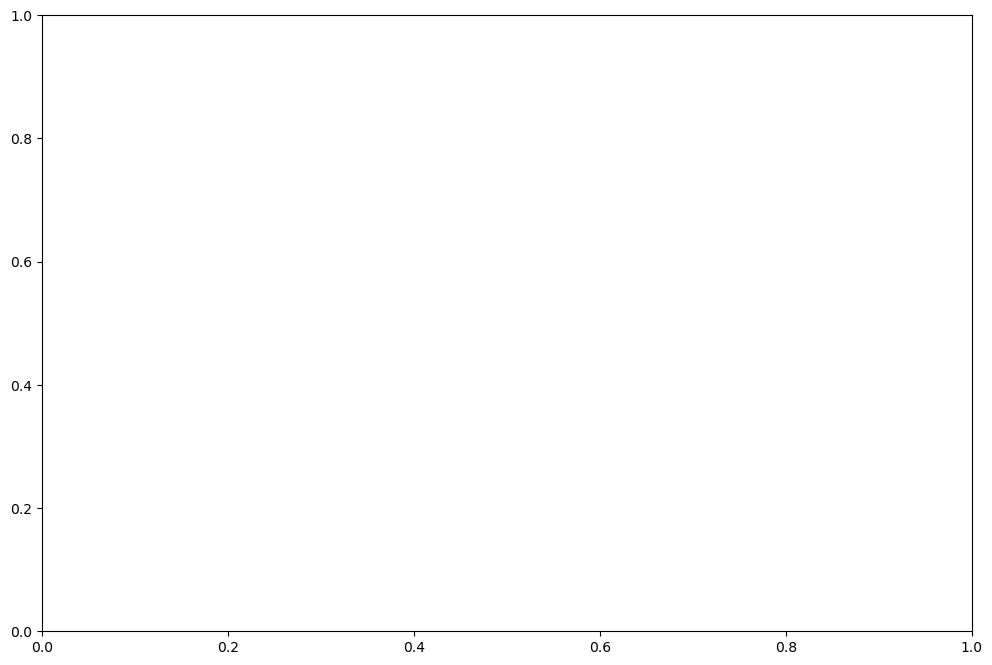

In [ ]:
# setting name of file to read
file_name = '3LoadCells_2'
# creating dataframe of file
log_df = log_df = pd.read_csv(f"Logging/{file_name}.csv") 
# removing measurents errors
log_df = log_df.drop(log_df[log_df.Distance > 90].index)
# plotting data
fig, ax = plt.subplots(figsize = (12, 8))
ax = log_df.plot(x='Timestamp', y='Distance', kind='line')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
# reading txt file and separating with spaces
file_name = 'FullSetup_Walking'
log_df = pd.read_csv(f"Logging/ExampleLogs/{file_name}.txt", header = None, delimiter=' ') 
  
# adding column headings 
log_df.columns = ['Timestamp', 'Foot_H', 'loadcell1H','loadcell2H', 'loadcell3H','fel','Foot_V','loadcell1V','loadcell2V', 'loadcell3V', 'DistanceName', 'Distance'] 

# dropping unnececary columns
log_df = log_df.drop(columns=['Foot_H', 'Foot_V','DistanceName','fel'])

plt.plot(log_df['Timestamp'], log_df['loadcell1H'],label="HögerInsida")
plt.plot(log_df['Timestamp'], log_df['loadcell2H'],label="HögerUtsida")
plt.plot(log_df['Timestamp'], log_df['loadcell3H'],label="HögerBak")
plt.plot(log_df['Timestamp'], log_df['loadcell1V'],label="VänsterInsida")
plt.plot(log_df['Timestamp'], log_df['loadcell2V'],label="VänsterUtsida")
plt.plot(log_df['Timestamp'], log_df['loadcell3V'],label="VänserBak")
plt.plot(log_df['Timestamp'], log_df['Distance'],label="Avstånd")
plt.legend()
plt.show()


ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

## Fourier transform on signals
We preform the fourier transform in order to see what frequencies we might want to filter out.
https://docs.scipy.org/doc/scipy/tutorial/fft.html

In [ ]:
# preforming the fourier transform and plotting using fft from scipy and plottig with plt

## Filtering
Using filters a lot of the noise from the different signals can be removed.
https://docs.scipy.org/doc/scipy/reference/signal.html

In [ ]:
# Signal filtering using scipy.signal

## other pre-precessing
I.E splitting the data into cycles of skiing and extracting the variables we want to input into the machine learning algorithm (How close the feet are togheter when the maximum pressure is reached, among others...).

In [ ]:
# splitting the data into cycles using some threshhold for the data (ex perhaps the switch of acceleration direction of one of the boots)

# extracting the variables we want to look at in the data (see rapport) and input into matrix.

## Machine learning

### train-test split
Splitting the data into a training set and a test set (validation)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
random_seed = 42
"""
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state=random_seed)
"""

### constructing model

In [ ]:
"""
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu,  
                                activity_regularizer=tf.keras.regularizers.L2(1e-5))) # change 128 based on amount of input vaiables
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu,
                                activity_regularizer=tf.keras.regularizers.L2(1e-5))) # play around whith size to see what works (overfit->smaller, underfit->larger(or add another layer))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.softmax))

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # could perhaps add loss here aswell
"""

### training model

In [ ]:
#model.fit(x_train,y_train,epochs=3) # probably add more epochs when we've found something that works

### validating model performance


In [ ]:
#val_loss, val_accuracy = model.evaluate(x_test,y_test)
#print(val_loss, val_accuracy)